In [95]:
!pip3 install statsmodels plotly tensorflow<2.11

zsh:1: no such file or directory: 2.11


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
df_weather_daily = pd.read_parquet('../data/01_interim/weather_daily_darksky_cleaned.parquet')

# Rename index time to Date
df_weather_daily.reset_index(inplace=True)
df_weather_daily.rename(columns={'time': 'Date'}, inplace=True)

# Convert to datetime
df_weather_daily['Date'] = pd.to_datetime(df_weather_daily['Date'])

# Order by date
df_weather_daily = df_weather_daily.sort_values(by='Date')

# Let be the first column
df_weather_daily = df_weather_daily.set_index('Date')

# Drop the index
df_weather_daily = df_weather_daily.reset_index()

# Check for missing dates
missing_dates = df_weather_daily['Date'].isnull().sum()
print(f"Missing dates: {missing_dates}")

# Check for duplicate dates
duplicate_dates = df_weather_daily['Date'].duplicated().sum()
print(f"Duplicate dates: {duplicate_dates}")

Missing dates: 0
Duplicate dates: 0


In [98]:
df_weather_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     881 non-null    datetime64[ns]
 1   temperatureMax           881 non-null    float64       
 2   windBearing              881 non-null    int64         
 3   icon                     881 non-null    category      
 4   dewPoint                 881 non-null    float64       
 5   cloudCover               881 non-null    float64       
 6   windSpeed                881 non-null    float64       
 7   pressure                 881 non-null    float64       
 8   apparentTemperatureHigh  881 non-null    float64       
 9   precipType               881 non-null    category      
 10  visibility               881 non-null    float64       
 11  humidity                 881 non-null    float64       
 12  apparentTemperatureLow   881 non-nul

In [99]:
df_consumption_daily = pd.read_parquet('../data/02_processed/parquet/group_4_daily.parquet')

# Convert to datetime
df_consumption_daily['Date'] = pd.to_datetime(df_consumption_daily['Date'])

In [100]:
df_consumption_daily.head()

,Acorn,Date,nb_pts,nb_clients,Conso_kWh
0,ACORN-C,2012-07-01,48,74.000000,10.305622
1,ACORN-C,2012-07-02,48,73.979167,10.222741
2,ACORN-C,2012-07-03,48,73.020833,10.202942
3,ACORN-C,2012-07-04,48,73.375000,9.481093
4,ACORN-C,2012-07-05,48,74.979167,9.526791


In [101]:
df_consumption_daily = df_consumption_daily.drop(columns=['nb_pts'])

In [102]:
# Check for missing dates in raw consumption data

cons = df_consumption_daily.copy()
cons_dates = set(cons['Date'])
full_range = pd.date_range(cons['Date'].min(), cons['Date'].max(), freq='D')
missing = sorted(set(full_range) - cons_dates)
print(f"Missing days in raw consumption: {len(missing)}")
if missing:
    print('First 10 missing:', [d.strftime('%Y-%m-%d') for d in missing[:10]])
    print('Largest gap:', missing[0], 'to', missing[-1], f"({(missing[-1]-missing[0]).days+1} days)")

Missing days in raw consumption: 0


In [103]:
df_weather_daily.head()

,Date,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-01,15.57,208,partly-cloudy-day,10.13,0.36,2.45,1009.46,15.57,rain,12.68,0.84,7.33,15.57,1.0,8.88,9.68,15.57,9.01,0.21
1,2011-11-02,15.19,134,partly-cloudy-night,10.23,0.39,4.39,1004.79,15.06,rain,11.83,0.87,13.99,15.19,1.0,13.99,8.88,15.06,7.33,0.24
2,2011-11-03,17.41,154,partly-cloudy-day,13.39,0.52,3.99,993.40,17.41,rain,12.15,0.89,12.52,17.41,1.0,12.52,12.79,17.41,12.79,0.27
3,2011-11-04,15.54,179,fog,12.03,0.50,2.62,995.54,15.54,rain,10.69,0.91,10.17,15.54,1.0,10.17,11.53,15.54,11.53,0.31
4,2011-11-05,13.94,346,fog,10.96,0.65,2.70,1007.39,13.94,rain,4.60,0.92,7.03,13.94,1.0,9.46,10.17,13.94,10.17,0.34


In [104]:
# Ensure Date is datetime and normalized to midnight
df_weather_daily['Date'] = pd.to_datetime(df_weather_daily['Date']).dt.normalize()

# Now check for missing dates
weather_dates = set(df_weather_daily['Date'])
full_range = pd.date_range(df_weather_daily['Date'].min(), df_weather_daily['Date'].max(), freq='D')
missing = sorted(set(full_range) - weather_dates)
print(f"Missing days in raw weather: {len(missing)}")
if missing:
    print('First 10 missing:', [d.strftime('%Y-%m-%d') for d in missing[:10]])
    print('Largest gap:', missing[0], 'to', missing[-1], f"({(missing[-1]-missing[0]).days+1} days)")

Missing days in raw weather: 3
First 10 missing: ['2012-10-28', '2013-10-27', '2014-01-01']
Largest gap: 2012-10-28 00:00:00 to 2014-01-01 00:00:00 (431 days)


In [105]:
df = pd.merge(df_weather_daily, df_consumption_daily, on='Date').reset_index(drop=True)

In [106]:
period = df.Date.min(), df.Date.max()
print(f"Data period: {period[0]} to {period[1]}")

Data period: 2012-07-01 00:00:00 to 2014-01-12 00:00:00


In [107]:
test_percentage = 2/(period[1]-period[0]).days
test_percentage

0.0035714285714285713

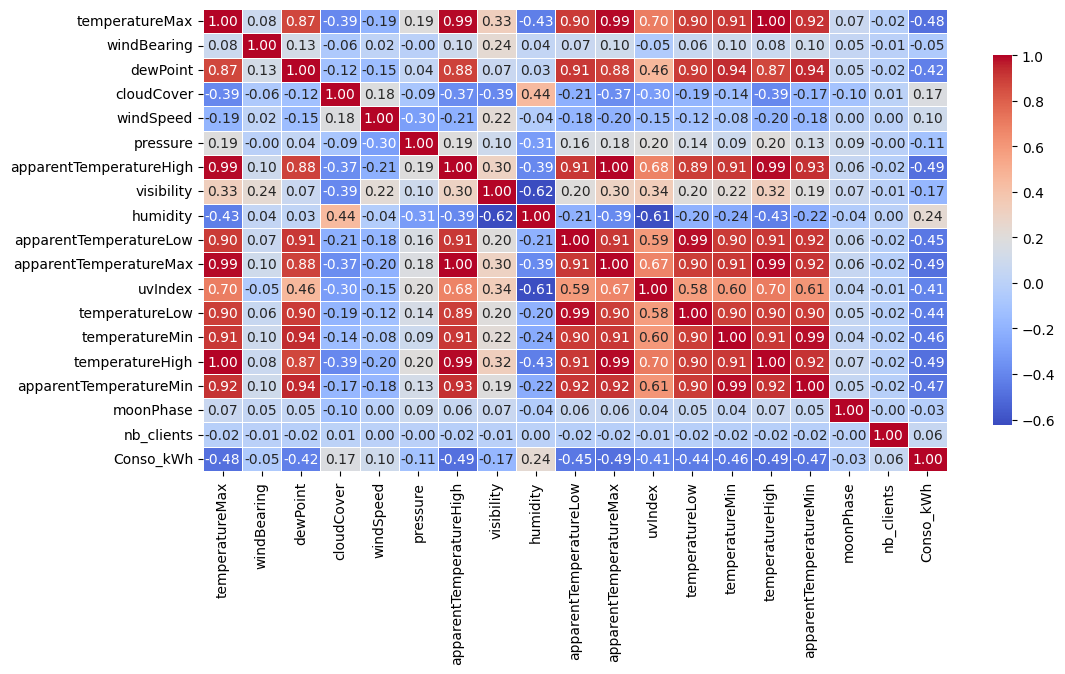

In [108]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            linewidths=0.5, 
            cbar_kws={"shrink": .8})
plt.show()

In [109]:
df.head()

,Date,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,...,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,Acorn,nb_clients,Conso_kWh
0,2012-07-01,17.58,192,partly-cloudy-day,12.17,0.56,4.51,1015.49,17.58,rain,...,17.58,6.0,15.43,12.47,17.58,12.47,0.45,ACORN-C,74.000000,10.305622
1,2012-07-01,17.58,192,partly-cloudy-day,12.17,0.56,4.51,1015.49,17.58,rain,...,17.58,6.0,15.43,12.47,17.58,12.47,0.45,ACORN-F,586.000000,8.158386
2,2012-07-01,17.58,192,partly-cloudy-day,12.17,0.56,4.51,1015.49,17.58,rain,...,17.58,6.0,15.43,12.47,17.58,12.47,0.45,ACORN-P,87.958333,5.758356
3,2012-07-02,18.81,192,partly-cloudy-day,15.16,0.78,3.64,1013.77,18.81,rain,...,18.81,5.0,15.95,15.43,18.81,15.52,0.49,ACORN-C,73.979167,10.222741
4,2012-07-02,18.81,192,partly-cloudy-day,15.16,0.78,3.64,1013.77,18.81,rain,...,18.81,5.0,15.95,15.43,18.81,15.52,0.49,ACORN-F,590.312500,7.956669


In [110]:
holidays = pd.read_csv('../data/00_raw/uk_bank_holidays.csv')
holidays.head()

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [111]:
holidays = pd.to_datetime(holidays['Bank holidays'])

In [112]:
df['is_holiday'] = df['Date'].dt.date.isin(holidays.dt.date)

# convert to int
df['is_holiday'] = df['is_holiday'].astype(int)

In [113]:
# Extract hour, day of week, and month as numeric columns:

df["dayofweek"] = df["Date"].dt.dayofweek
df["month"]     = df["Date"].dt.month
df["dayofyear"] = df["Date"].dt.day_of_year

In [114]:
# Separate in 3 DF for each ACORN: ACORN-C, ACORN-P, ACORN-F:

df_acorn_c = df[df['Acorn'] == 'ACORN-C'].drop(columns=['Acorn'])
df_acorn_p = df[df['Acorn'] == 'ACORN-P'].drop(columns=['Acorn'])
df_acorn_f = df[df['Acorn'] == 'ACORN-F'].drop(columns=['Acorn'])

# Reset index for each ACORN DF

df_acorn_c = df_acorn_c.reset_index(drop=True)
df_acorn_p = df_acorn_p.reset_index(drop=True)
df_acorn_f = df_acorn_f.reset_index(drop=True)

In [115]:
df_acorn_c.columns

Index(['Date', 'temperatureMax', 'windBearing', 'icon', 'dewPoint',
       'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh',
       'precipType', 'visibility', 'humidity', 'apparentTemperatureLow',
       'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin',
       'temperatureHigh', 'apparentTemperatureMin', 'moonPhase', 'nb_clients',
       'Conso_kWh', 'is_holiday', 'dayofweek', 'month', 'dayofyear'],
      dtype='object')

In [116]:
def add_features(df, target_col='Conso_kWh'):
    """
    Adds feature engineering for each DataFrame:
    - Lags (1, 7, 14 days) to capture inertia and weekly seasonality
    - Rolling windows (7-day mean and standard deviation)
    - HDD/CDD (heating/cooling degree days)
    - Categorical variables (day of week and month)
    """
    df_enhanced = df.copy()
    
    # Sort by date to ensure chronological order
    df_enhanced = df_enhanced.sort_values('Date').reset_index(drop=True)
    
    # 1. LAGS - capture inertia and weekly seasonality
    df_enhanced['lag1'] = df_enhanced[target_col].shift(1)    # 1-day lag
    df_enhanced['lag7'] = df_enhanced[target_col].shift(7)    # 7-day lag (weekly)
    df_enhanced['lag14'] = df_enhanced[target_col].shift(14)  # 14-day lag (bi-weekly)
    
    # 2. ROLLING WINDOWS - 7-day mean and standard deviation
    df_enhanced['roll7_mean'] = df_enhanced[target_col].rolling(window=7, min_periods=1).mean()
    df_enhanced['roll7_std'] = df_enhanced[target_col].rolling(window=7, min_periods=1).std()
    
    # 3. HDD and CDD - Heating/Cooling degree days
    # HDD (Heating Degree Days) - base 18°C for heating
    df_enhanced['HDD'] = np.maximum(18 - df_enhanced['temperatureMax'], 0)
    
    # CDD (Cooling Degree Days) - base 21°C for cooling
    df_enhanced['CDD'] = np.maximum(df_enhanced['temperatureMax'] - 21, 0)
    
    # 4. CATEGORICAL VARIABLES - day of week and month
    # Day of week as categorical string (Mon, Tue, Wed, etc.)
    df_enhanced['dow'] = df_enhanced['Date'].dt.day_name()
    
    # Month as categorical string
    df_enhanced['month_name'] = df_enhanced['Date'].dt.month_name()
    
    # Keep numeric versions for flexibility
    # (dayofweek and month already exist)
    
    return df_enhanced

In [117]:
# Apply feature engineering to the three DataFrames
print("Applying feature engineering...")

# ACORN-C
df_acorn_c_enhanced = add_features(df_acorn_c, target_col='Conso_kWh')
print(f"ACORN-C: {df_acorn_c_enhanced.shape[0]} rows, {df_acorn_c_enhanced.shape[1]} columns")

# ACORN-P
df_acorn_p_enhanced = add_features(df_acorn_p, target_col='Conso_kWh')
print(f"ACORN-P: {df_acorn_p_enhanced.shape[0]} rows, {df_acorn_p_enhanced.shape[1]} columns")

# ACORN-F
df_acorn_f_enhanced = add_features(df_acorn_f, target_col='Conso_kWh')
print(f"ACORN-F: {df_acorn_f_enhanced.shape[0]} rows, {df_acorn_f_enhanced.shape[1]} columns")

print("\nFeature engineering completed!")

Applying feature engineering...
ACORN-C: 559 rows, 35 columns
ACORN-P: 559 rows, 35 columns
ACORN-F: 559 rows, 35 columns

Feature engineering completed!


In [118]:
# Visualize the new features for ACORN-C
print("New features added:")
print("="*50)

# Show the first rows with the new features
feature_cols = ['Date', 'Conso_kWh', 'lag1', 'lag7', 'lag14', 'roll7_mean', 'roll7_std', 'HDD', 'CDD', 'dow', 'month_name']
print("\nFirst 10 rows with new features (ACORN-C):")
print(df_acorn_c_enhanced[feature_cols].head(10))

# Descriptive statistics of new numeric features
print("\nStatistics of new numeric features:")
numeric_features = ['lag1', 'lag7', 'lag14', 'roll7_mean', 'roll7_std', 'HDD', 'CDD']
print(df_acorn_c_enhanced[numeric_features].describe())

New features added:

First 10 rows with new features (ACORN-C):
        Date  Conso_kWh       lag1       lag7  lag14  roll7_mean  roll7_std  \
0 2012-07-01  10.305622        NaN        NaN    NaN   10.305622        NaN   
1 2012-07-02  10.222741  10.305622        NaN    NaN   10.264181   0.058606   
2 2012-07-03  10.202942  10.222741        NaN    NaN   10.243768   0.054474   
3 2012-07-04   9.481093  10.202942        NaN    NaN   10.053099   0.383923   
4 2012-07-05   9.526791   9.481093        NaN    NaN    9.947838   0.407367   
5 2012-07-06   9.484541   9.526791        NaN    NaN    9.870621   0.410527   
6 2012-07-07  10.193990   9.484541        NaN    NaN    9.916817   0.394185   
7 2012-07-08  10.766833  10.193990  10.305622    NaN    9.982704   0.495523   
8 2012-07-09  10.242705  10.766833  10.222741    NaN    9.985556   0.497190   
9 2012-07-10  10.293786  10.242705  10.202942    NaN    9.998534   0.504935   

    HDD   CDD        dow month_name  
0  0.42  0.00     Sunday    

In [119]:
if 'Date' not in df_acorn_c_enhanced.columns:
    df_acorn_c_enhanced = df_acorn_c_enhanced.reset_index()

if 'Date' not in df_acorn_p_enhanced.columns:
    df_acorn_p_enhanced = df_acorn_p_enhanced.reset_index()

if 'Date' not in df_acorn_f_enhanced.columns:
    df_acorn_f_enhanced = df_acorn_f_enhanced.reset_index()

# Save each DataFrame with enhanced features
df_acorn_c_enhanced.to_parquet('../data/02_processed/daily_parquet_enhanced/acorn_c_enhanced.parquet', index=False)
df_acorn_p_enhanced.to_parquet('../data/02_processed/daily_parquet_enhanced/acorn_p_enhanced.parquet', index=False)
df_acorn_f_enhanced.to_parquet('../data/02_processed/daily_parquet_enhanced/acorn_f_enhanced.parquet', index=False)

In [120]:
# DATA GAP DIAGNOSIS: Check for Missing Dates in Each ACORN Group
import pandas as pd

for name, df in [('df_acorn_c', df_acorn_c), ('df_acorn_p', df_acorn_p), ('df_acorn_f', df_acorn_f)]:
    print(f'\n{name}:')
    print(f'  Rows: {len(df)}')
    print(f'  Date range: {df["Date"].min()} to {df["Date"].max()}')
    expected_days = (df['Date'].max() - df['Date'].min()).days + 1
    print(f'  Expected days: {expected_days}')
    print(f'  Missing days: {expected_days - len(df)}')
    # Check for duplicates
    duplicates = df['Date'].duplicated().sum()
    print(f'  Duplicate dates: {duplicates}')
    # List first 10 missing dates
    full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    actual_dates = set(df['Date'])
    missing_dates = sorted(set(full_date_range) - actual_dates)
    if missing_dates:
        print(f'  First 10 missing dates: {[d.strftime("%Y-%m-%d") for d in missing_dates[:10]]}')
        if len(missing_dates) > 10:
            print(f'  ... and {len(missing_dates) - 10} more missing dates')
        # Find largest consecutive missing period
        missing_df = pd.DataFrame({'missing_date': missing_dates})
        missing_df['prev_date'] = missing_df['missing_date'].shift(1)
        missing_df['gap'] = (missing_df['missing_date'] - missing_df['prev_date']).dt.days > 1
        missing_df['group'] = missing_df['gap'].cumsum()
        gap_summary = missing_df.groupby('group').agg({
            'missing_date': ['min', 'max', 'count']
        }).round(0)
        gap_summary.columns = ['Start_Missing', 'End_Missing', 'Days_Missing']
        gap_summary = gap_summary.sort_values('Days_Missing', ascending=False)
        print('  Largest consecutive missing periods:')
        print(gap_summary.head(3).to_string())
    else:
        print('  No missing dates!')


df_acorn_c:
  Rows: 559
  Date range: 2012-07-01 00:00:00 to 2014-01-12 00:00:00
  Expected days: 561
  Missing days: 2
  Duplicate dates: 1
  First 10 missing dates: ['2012-10-28', '2013-10-27', '2014-01-01']
  Largest consecutive missing periods:
      Start_Missing End_Missing  Days_Missing
group                                        
0        2012-10-28  2012-10-28             1
1        2013-10-27  2013-10-27             1
2        2014-01-01  2014-01-01             1

df_acorn_p:
  Rows: 559
  Date range: 2012-07-01 00:00:00 to 2014-01-12 00:00:00
  Expected days: 561
  Missing days: 2
  Duplicate dates: 1
  First 10 missing dates: ['2012-10-28', '2013-10-27', '2014-01-01']
  Largest consecutive missing periods:
      Start_Missing End_Missing  Days_Missing
group                                        
0        2012-10-28  2012-10-28             1
1        2013-10-27  2013-10-27             1
2        2014-01-01  2014-01-01             1

df_acorn_f:
  Rows: 559
  Date range: 2

In [121]:
df_test = pd.read_parquet('../data/02_processed/daily_parquet_enhanced/acorn_c_enhanced.parquet')

def report_missing_days(df, date_col='Date'):
    # Ensure datetime and normalize to midnight
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col]).dt.normalize()
    min_date = df[date_col].min()
    max_date = df[date_col].max()
    full_range = pd.date_range(min_date, max_date, freq='D')
    actual_dates = set(df[date_col])
    missing = sorted(set(full_range) - actual_dates)
    print(f"Date range: {min_date} to {max_date}")
    print(f"Total expected days: {len(full_range)}")
    print(f"Actual rows: {len(df)}")
    print(f"Missing days: {len(missing)}")
    if missing:
        print('First 10 missing:', [d.strftime('%Y-%m-%d') for d in missing[:10]])
        if len(missing) > 10:
            print(f"... and {len(missing)-10} more missing days")
    else:
        print("No missing days!")

# Usage for df_acorn_p:
report_missing_days(df_test)

Date range: 2012-07-01 00:00:00 to 2014-01-12 00:00:00
Total expected days: 561
Actual rows: 559
Missing days: 3
First 10 missing: ['2012-10-28', '2013-10-27', '2014-01-01']
